This is a code review of Josh Cohen's original NBA Analysis:
https://github.com/joshc3453/NBA_Analysis/blob/main/nba_scraper_players_22_23_clean.ipynb

This is for a Buffalo Data Science Community talk about Bad Data Science Coding Practices.

# NBA 22-23 Analysis & Classification

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [2]:
# @refactored
# Extract functionality that is commonly used into its own .py file
import warnings
warnings.filterwarnings('ignore')

import nba_func as nf

# Web Scraping & Merging Datasets

In [3]:
url = 'https://www.basketball-reference.com/leagues/NBA_2023_totals.html'
html = urlopen(url)
soup = BeautifulSoup(html, features='lxml')

In [4]:
headers = [th.getText() for th in soup.findAll('tr')[0].findAll('th')]
rows = soup.findAll('tr')[1:]
rows_data = [[td.getText() for td in rows[i].findAll('td')]
                     for i in range(len(rows))]
headers = headers[1:]

In [5]:
nba = pd.DataFrame(rows_data, columns = headers)
nba = nba.mask(nba.eq('None')).dropna()
nba = nba.apply(pd.to_numeric, errors='ignore')

In [ ]:
# @badcode
# Mid-code import
# This may cause a reproducibility issue - people may not be able to run your code because they won't
# have access to your Google Drive.  Furthermore, there is no insight on how NBA_22_23.xlsx was generated.

# @badcode
# Bad variable name df2 does not tell me what the data actually is

from google.colab import drive
drive.mount('/content/gdrive')

mypath='/content/gdrive/MyDrive/'

fn = "NBA_22_23.xlsx"
df2 = pd.read_excel(mypath+fn)

In [ ]:
nba = nba.merge(df2, how='left', left_on='Player', right_on='player')

In [ ]:
# Dropping duplicate column 'player' and 'pos'
nba.drop(['player', 'pos'], axis=1, inplace=True)

# Feature Engineering

In [6]:
# @badcode
# Inconsistent naming convention - the 'PG' in PPG & MPG is uppercase, while it is lower case for 3Ppg, TRBpg, ASTpg

# @badcode
# Magic numbers - 0.44 in 0.44*nba['FTA']; 2 in 2*nba['TSA']

# @badcode
# DRY violation a lot of division by nba['G']

nba['PPG'] = nba['PTS']/nba['G']
nba['3Ppg'] = nba['3P']/nba['G']
nba['TRBpg'] = nba['TRB']/nba['G']
nba['ASTpg'] = nba['AST']/nba['G']
nba['TSA'] = nba['FGA']+(0.44*nba['FTA'])
nba['TS%'] = nba['PTS']/(2*nba['TSA'])
nba['MPG'] = nba['MP']/nba['G']

In [ ]:
# @refactored
for col in ('PTS', '3P', 'TRB', 'AST', 'MP'):
    nba[f'{col}pg'] = nba[col] / nba['G']
    
nba['TSA'] = nba['FGA']+(0.44*nba['FTA'])
nba['TS%'] = nba['PTS']/(2*nba['TSA'])

In [ ]:
# @badcode
# Useless comment - Adjusting decimal displays

# @badcode
# DRY violation

# @badcode
# Redundant code
# nba['number'].round(decimals=0) is redundant because it is converted to int in the next cell

# Adjusting decimal displays
nba['PPG'] = nba['PPG'].round(decimals=2)
nba['3Ppg'] = nba['3Ppg'].round(decimals=3)
nba['TRBpg'] = nba['TRBpg'].round(decimals=2)
nba['ASTpg'] = nba['ASTpg'].round(decimals=2)
nba['number'] = nba['number'].round(decimals=0)
nba['TS%'] = nba['TS%'].round(decimals=3)
nba['MPG'] = nba['MPG'].round(decimals=2)

In [ ]:
# @refactored
cols_to_round = dict.fromkeys(('PPG', 'TRBpg', 'ASTpg', 'MPG'), 2)
cols_to_round.update({'3Ppg': 3, 'TS%': 3})
nba = nba.round(cols_to_round)

In [ ]:
# @badcode
# Useless comment - Converting dtypes

# @badcode
# Confounding / similar naming
# height_inches vs height_in

# @badcode
# Inconsistent naming
# the unit of measurement is spelled out in height_feet, height_inches, but abbreviation is used for height_in, weight_lbs

# @badcode
# DRY Violation

# Converting dtypes
nba['number'] = nba['number'].astype('Int64')
nba['height_feet'] = nba['height_feet'].astype('Int64')
nba['height_inches'] = nba['height_inches'].astype('Int64')
nba['height_in'] = nba['height_in'].astype('Int64')
nba['weight_lbs'] = nba['weight_lbs'].astype('Int64')
nba['birth_day'] = nba['birth_day'].astype('Int64')
nba['birth_year'] = nba['birth_year'].astype('Int64')

In [ ]:
# @refactored
int_cols = ['number', 'height_feet', 'height_inches', 'height_in', 'weight_lbs', 'birth_day', 'birth_year']
nba[int_cols] = nba[int_cols].astype('Int64')

In [ ]:
# @badcode
# Useless comment

# Renaming similarly-named column
nba.rename(columns={"height_in": "total_height_in"}, inplace=True)

In [ ]:
nba.head()

# Data Analysis

## Team Points Per Game

In this analysis, I will extract team points per game using only individual player data. This will be accomplished by grouping the dataframe by team and finding the maximum amount of games played by a player for that team. This should give us the total games played by that team. Note: This assumes that at least one player from each team has played in every game so far this season.
I then divide the team's total points by the games played to get the team's points per game.

In [ ]:
# @badcode
# Useless comments

# @badcode
# We only want to calculate Team Points Per Game
# However, we are creating unneccessary dataframes using nba.groupby(by='Tm').max() and nba.groupby(by='Tm').sum().
# In the 2 groupby examples, we are calculating the max and sum for all numeric columns.  
# This is overkill for just calculating Team Points Per Game

# Finding the max games played by a player on each team
team_max_df = nba.groupby(by='Tm').max()
# Finding the total points scored by each team
team_sum_df = nba.groupby(by='Tm').sum()
# Creating a points per game feature for the dataframe
team_sum_df['team_ppg'] = team_sum_df['PTS']/team_max_df['G'].values
# Formatting
team_sum_df['team_ppg'] = team_sum_df['team_ppg'].round(decimals=1)
team_sum_df.reset_index(inplace=True)
# Viewing teams and points per game, sorted
team_sum_df = team_sum_df[['Tm', 'team_ppg']].sort_values(by='team_ppg', ascending=False)
team_sum_df

In [ ]:
# @badcode
# Bad assumption
# We assume 'Note: This assumes that at least one player from each team has played in every game so far this season.'
# Because of this assumption, in the code above, we use team_max_df['G'].values in the denominator to calculate Team Points Per Game

# In an NBA season, all teams should play the same amount of games.  However, when we check the code for the denominator,
# our assumption is incorrect.
nba.groupby('Tm')['G'].max()

In [7]:
# @refactored
n_games_per_team_per_season = 82
team_ppg = (nba.groupby(by='Tm')['PTS'].sum() / n_games_per_team_per_season).sort_values(ascending=False).round(1)
team_ppg

# TOT stands for Two Other Teams - meaning a player played for two or more teams that year

Tm
TOT    395.1
SAC    120.7
GSW    118.9
ATL    118.4
BOS    117.9
OKC    117.5
LAL    117.2
UTA    117.1
MIL    116.9
MEM    116.9
IND    116.3
NYK    116.0
DEN    115.8
MIN    115.8
PHI    115.2
NOP    114.4
DAL    114.2
PHO    113.6
LAC    113.6
POR    113.4
BRK    113.4
WAS    113.2
CHI    113.1
SAS    113.0
TOR    112.9
CLE    112.3
ORL    111.4
CHO    111.0
HOU    110.7
DET    110.3
MIA    109.5
Name: PTS, dtype: float64

## Top 5 Player Statistics

Top 5 player statistics uses a minimum game threshold of over 13 games. At this point in the season, 13 seems to capture active players while weeding out less active players. We don't want players with only a few games played to skew or inflate our results. Additionally, the results below are exactly inline with ESPN's statistics.

### Points Per Game

In [8]:
# @badcode
# DRY violation
# The same code pattern is repeated throughout

# @badcode
# DRY violation
# top_5_<<stat_name>> is used as the variable name.  What happens if you are asked to get the top 3 or top 10?
# You would have to change it in the code, as well as the variable name

# @badcode
# DRY violation
# 17 and 13 are repeated multiple times - they should be assigned to a variable

# @badcode
# Inconsistent code / magic number - In the text, we mention that we use 13 as a minimum game threshold.
# However, we see that 17 is also used.

top_5_ppg = nba[['Player', 'G', 'Tm', 'PPG']]
top_5_ppg[top_5_ppg['G']>17].sort_values('PPG', ascending=False)[:5]

,Player,G,Tm,PPG
191,Joel Embiid,66,PHI,33.075758
166,Luka Dončić,66,DAL,32.393939
387,Damian Lillard,58,POR,32.172414
217,Shai Gilgeous-Alexander,68,OKC,31.397059
12,Giannis Antetokounmpo,63,MIL,31.095238


### Assists

In [9]:
top_5_ast = nba[['Player', 'G', 'Tm', 'ASTpg']]
top_5_ast[top_5_ast['G']>17].sort_values('ASTpg', ascending=False)[:5]

,Player,G,Tm,ASTpg
254,James Harden,58,PHI,10.655172
248,Tyrese Haliburton,56,IND,10.446429
701,Trae Young,73,ATL,10.150685
330,Nikola Jokić,69,DEN,9.826087
164,Spencer Dinwiddie,26,BRK,9.076923


### 3 Pointers Made

In [10]:
top_5_3p = nba[['Player', 'G', 'Tm', '3Ppg']]
top_5_3p[top_5_3p['G']>13].sort_values('3Ppg', ascending=False)[:5]

,Player,G,Tm,3Ppg
144,Stephen Curry,56,GSW,4.875000
621,Klay Thompson,69,GSW,4.362319
387,Damian Lillard,58,POR,4.206897
25,LaMelo Ball,36,CHO,4.000000
443,Donovan Mitchell,68,CLE,3.602941


### Rebounds

In [11]:
top_5_reb = nba[['Player', 'G', 'Tm', 'TRBpg']]
top_5_reb[top_5_reb['G']>13].sort_values('TRBpg', ascending=False)[:5]

,Player,G,Tm,TRBpg
146,Anthony Davis,56,LAL,12.535714
570,Domantas Sabonis,79,SAC,12.316456
330,Nikola Jokić,69,DEN,11.840580
12,Giannis Antetokounmpo,63,MIL,11.777778
220,Rudy Gobert,70,MIN,11.628571


### Refactored Top Stats

In [12]:
# @badcode
# Logic Issues - There are players who have played for multiple teams during the same season
# However, this is not taken into account when we look at the top players
nba.loc[nba['Player'].duplicated(), ['Player', 'G']]

,Player,G
6,Nickeil Alexander-Walker,36
7,Nickeil Alexander-Walker,23
17,Ryan Arcidiacono,11
18,Ryan Arcidiacono,9
27,Mo Bamba,40
...,...,...
657,T.J. Warren,16
668,Russell Westbrook,52
669,Russell Westbrook,21
694,James Wiseman,21


In [13]:
# For example, For this particular player, because we didn't group by Player before using the G > 13 filter,
# he is only listed as having score 26 points in the season, when in reality, he scored 52 points
nba.loc[nba['Player']=='Ryan Arcidiacono', ['G', 'PTS']]

,G,PTS
16,20,26
17,11,3
18,9,23


In [14]:
# @refactored code
min_games_played_threshold = 13
top_n = 5
eligible_candidates = nba[nba['G'] > min_games_played_threshold]

top_players = {
    stat: nf.sort_top_players_by_stat(eligible_candidates[['Player', 'G', 'Tm', stat]], stat, top_n)
    for stat in ('PPG', 'ASTpg', '3Ppg', 'TRBpg')
}

In [15]:
top_players['PPG']

,Player,G,Tm,PPG
191,Joel Embiid,66,PHI,33.075758
166,Luka Dončić,66,DAL,32.393939
387,Damian Lillard,58,POR,32.172414
217,Shai Gilgeous-Alexander,68,OKC,31.397059
12,Giannis Antetokounmpo,63,MIL,31.095238


In [16]:
top_players['ASTpg']

,Player,G,Tm,ASTpg
254,James Harden,58,PHI,10.655172
248,Tyrese Haliburton,56,IND,10.446429
701,Trae Young,73,ATL,10.150685
330,Nikola Jokić,69,DEN,9.826087
164,Spencer Dinwiddie,26,BRK,9.076923


## Free Throw Analysis

I first create a new dataframe, "ft_df" to analyze player free throws. Next, I create a new feature called "points_forgone" which is a measure of free throws made minus free throws attempted. Since every free throw counts for one point each, one missed free throw equals one missed point, or a point forgone.
> All Games qualifier is on pace for at least 125 made free throws

In [17]:
# @badcode
# Inconsistent code - for the 'PPG', 'ASTpg', '3Ppg', 'TRBpg' stats, we look at players who have played at at least 13 
# games.  However, for free throws, we don't include that filter.  There should be a comment explaining why the filter
# is not applied

ft_df = nba[['Player', 'FT', 'FTA', 'FT%']]
ft_df['points_forgone'] = ft_df['FTA']-ft_df['FT']

In [18]:
# @badcode
# Useless comment - a better comment would be the rationale behind using a minimum of 30 free throw attempts

# @badcode
# DRY violation - 30 & 5

# A look at the top 5 players by free throw percentage with
# a minimum of 30 free throw attempts.
ft_df[ft_df['FTA']>30].sort_values('FT%', ascending=False)[:5]

,Player,FT,FTA,FT%,points_forgone
350,Luke Kennard,37,39,0.949,2
306,Kyrie Irving,89,94,0.947,5
181,Kevin Durant,267,286,0.934,19
275,Tyler Herro,170,182,0.934,12
108,Vlatko Čančar,38,41,0.927,3


In [19]:
ft_df.sort_values('points_forgone', ascending=False)[:5]

,Player,FT,FTA,FT%,points_forgone
12,Giannis Antetokounmpo,498,772,0.645,274
166,Luka Dončić,515,694,0.742,179
29,Paolo Banchero,394,534,0.738,140
534,Julius Randle,402,531,0.757,129
452,Ja Morant,372,497,0.748,125


In [20]:
ft_df[ft_df['FTA'] > 30]['FT%'].mean()

0.7659299065420561

In [21]:
# @refactored
nf.sort_top_players_by_stat(ft_df[ft_df['FTA']>30], 'FT%', top_n)

,Player,FT,FTA,FT%,points_forgone
350,Luke Kennard,37,39,0.949,2
306,Kyrie Irving,89,94,0.947,5
181,Kevin Durant,267,286,0.934,19
275,Tyler Herro,170,182,0.934,12
108,Vlatko Čančar,38,41,0.927,3


In [22]:
# @refactored
nf.sort_top_players_by_stat(ft_df, 'points_forgone', top_n)

,Player,FT,FTA,FT%,points_forgone
12,Giannis Antetokounmpo,498,772,0.645,274
166,Luka Dončić,515,694,0.742,179
29,Paolo Banchero,394,534,0.738,140
534,Julius Randle,402,531,0.757,129
452,Ja Morant,372,497,0.748,125


In [ ]:
# @badcode
# Magic number - it's bad practice to refer to columns by their integer location (i.e. 0 & 28).
# What happens if the order of your columns changed, or if the columns were added or removed?
# You would then have to change your code.

# @badcode
# DRY violation - sort_values is called twice.  It's expensive and unnecessary.

# Finding the player on each team with the most points scored
for i in nba['Tm'].unique():
  print('*****')
  print('Team:', i)
  print(nba[nba['Tm']==i].sort_values(by='PTS', ascending=False).iloc[0][0], ':',
        nba[nba['Tm']==i].sort_values(by='PTS', ascending=False).iloc[0][28],
        'pts')
print('*****')

In [ ]:
# @badcode
# DRY violation - this code is very similar as the code above

# @badcode
# vague variable name - top_player_list
# There are many ways to define who is the best (for ex. the best rebounder may not be the best scorer)
# Better variable name - top_scorer_list since we are looking at points

top_player_list = []
for i in nba['Tm'].unique():
  top_player_list.append(nba[nba['Tm']==i].sort_values(by='PTS', ascending=False).iloc[0][0])

In [ ]:
# @badcode
# The comment and code logic is wrong - notice that there are multiple players from the same team
# ex. TOT, BRK, etc.  However, we only want to grab the top points scorer from each team.
# Therefore, each team should only have 1 entry.

# This query returns a dataframe of the top player for each team (PTS)
top_player_df = nba.query("Player == @top_player_list")
top_player_df

In [ ]:
# @refactored
top_scorers = nba.sort_values('PTS', ascending=False)
best_scorers_by_team = top_scorers.groupby('Tm').head(1)
for Team, player_name, pts in best_scorers_by_team[['Tm', 'Player', 'PTS']].to_records(index=False):
    print(f'*****\n{Team=}\n{player_name}: {pts=}')

In [ ]:
best_scorers_by_team

In [ ]:
# Original code dataframe
top_player_df['Tm'].duplicated().sum()

In [ ]:
# Refactored code dataframe
best_scorers_by_team['Tm'].duplicated().sum()

# Data Visualization

In [ ]:
# @badcode
# Magic number - 50
# What's the significance of 50?  Why not 49, 48?

# @badcode
# DRY violation - 50 repeated multiple times

plt.hist(nba[nba['3PA']>50]['3P%'], facecolor='orange', edgecolor='brown', bins=20)
plt.title('NBA 3 Point Percentage for Players with over 50 Three Point Attempts')
plt.xlabel('3P%')
plt.ylabel('Frequency')
plt.show()
print(f'Average 3P%: ', {nba[nba['3PA']>50]['3P%'].mean()*100})

# Machine Learning

In this section, I will build a machine learning classification model to try to predict which position a player plays based on their player statistics. I begin by dropping unncessary columns to reduce noise from the data. For example, age should not have any effect on which position a player plays. Additionally, I will remove shot percentages in favor or shot attempts and shots made (For example, I will drop 3P% and keep 3P and 3PA).  I will also drop Offensive Rebounds (ORB) and Defensive Rebounds (DRB) and keep Total Rebounds (TRB)

In [23]:
# @badcode
# Mid-code violation
# Imports should be at the top

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
# @badcode
# This should be in the Feature Engineering section

nba['BLKpg']=nba['BLK']/nba['G']
nba['PFpg']=nba['PF']/nba['G']
nba['TOVpg']=nba['TOV']/nba['G']

In [ ]:
ml_df = nba[['PPG', 'TRBpg', 'ASTpg', 'BLKpg', 'TOVpg', 'PFpg',
             'total_height_in', 'weight_lbs', 'Pos']]

In [25]:
# Use these features for refactoring demo because we don't have access to 'total_height_in', 'weight_lbs'
ml_df = nba[['PPG', 'TRBpg', 'ASTpg', 'BLKpg', 'TOVpg', 'PFpg', 'Pos']]

In [26]:
X = ml_df.iloc[:, :-1]
y = ml_df.iloc[:, -1:]

In [27]:
# @badcode
# This should have a seed via the random_state argument to ensure repeatability

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.30)

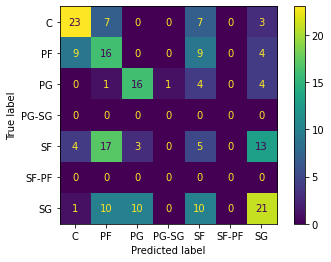

Decision Tree Classifier Accuracy Score:  0.39705882352941174


In [28]:
# @badcode
# DRY violation

# @badcode
# Not good practice to re-use variables

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

predictions = dtc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dtc.classes_)
acc = acc = accuracy_score(y_test, predictions)
disp.plot()
plt.show()
print('Decision Tree Classifier Accuracy Score: ', acc)

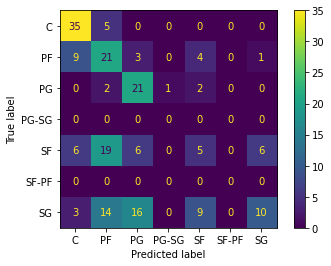

K Nearest Neighbor Classifier Accuracy Score:  0.45098039215686275


In [29]:
knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train, y_train)

predictions = knc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=knc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knc.classes_)
disp.plot()

plt.show()
acc = acc = accuracy_score(y_test, predictions)
print('K Nearest Neighbor Classifier Accuracy Score: ', acc)

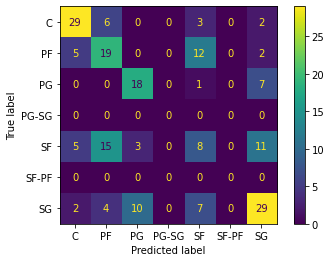

Random Forest Accuracy Score:  0.5049019607843137


In [30]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

plt.show()
acc = acc = accuracy_score(y_test, predictions)
print('Random Forest Accuracy Score: ', acc)

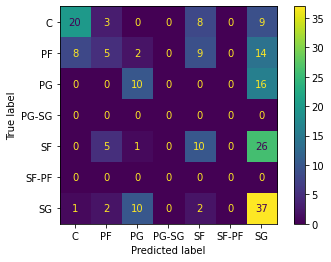

Gaussian Naive Bayes Accuracy Score:  0.4019607843137255


In [31]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

predictions = gnb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gnb.classes_)
disp.plot()
plt.show()
acc = acc = accuracy_score(y_test, predictions)
print('Gaussian Naive Bayes Accuracy Score: ', acc)

DecisionTreeClassifier Accuracy: 0.39705882352941174
KNeighborsClassifier Accuracy: 0.45098039215686275
RandomForestClassifier Accuracy: 0.5049019607843137
GaussianNB Accuracy: 0.4019607843137255


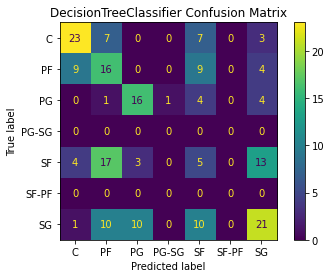

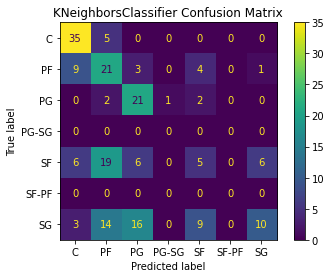

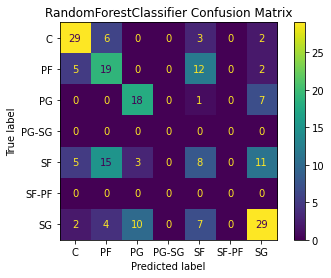

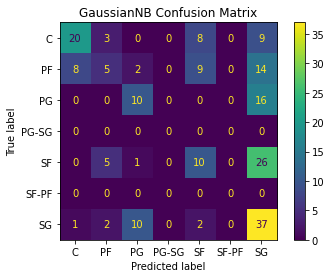

In [32]:
for fitted_model in (dtc, knc, rfc, gnb):
    nf.display_confusion_matrix(fitted_model, X_test, y_test)

In [ ]:
ml_df.corr()

In [ ]:
sns.boxplot(nba['Pos'], nba['total_height_in'])

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
fig = sns.boxplot(data=nba, x='Pos', y='weight_lbs')
fig.set_title('Weight (lbs.)')


plt.subplot(2, 2, 2)
fig = sns.boxplot(data=nba, x='Pos', y='total_height_in')
fig.set_title('Height (in.)')

plt.subplot(2, 2, 3)
fig = sns.boxplot(data=nba, x='Pos', y='TRBpg')
fig.set_title('Rebounds per game')

plt.subplot(2, 2, 4)
fig = sns.boxplot(data=nba, x='Pos', y='BLKpg')
fig.set_title('Blocks per game')

plt.tight_layout()